# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.


## Task 1: Dependencies and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [24]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121 langchain_huggingface==0.2.0

In [1]:
import os
import getpass
import uuid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import time
from langchain.storage import LocalFileStore
from langchain.embeddings import CacheBackedEmbeddings
from langchain_huggingface import HuggingFaceEndpoint
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings
from langchain_core.caches import InMemoryCache
from langchain_core.globals import set_llm_cache

We'll need an HF Token:

In [2]:
os.environ["HF_TOKEN"] = getpass.getpass("HF Token Key:")

And the LangSmith set-up:

In [3]:
os.environ["LANGCHAIN_PROJECT"] = f"AIM Session 16 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

Let's verify our project so we can leverage it in LangSmith later.

In [4]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Session 16 - 8fb65977


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

In [5]:
file_path = "./DeepSeek_R1.pdf"
file_path

'./DeepSeek_R1.pdf'

We'll define our chunking strategy.

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [7]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [8]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings
import hashlib

YOUR_EMBED_MODEL_URL = "https://yij47k87rjciyxy7.us-east-1.aws.endpoints.huggingface.cloud"

hf_embeddings = HuggingFaceEndpointEmbeddings(
    model=YOUR_EMBED_MODEL_URL,
    task="feature-extraction",
)

collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=768, distance=Distance.COSINE),
)

# Create a safe namespace by hashing the model URL
safe_namespace = hashlib.md5(hf_embeddings.model.encode()).hexdigest()

store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    hf_embeddings, store, namespace=safe_namespace, batch_size=32
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 1})

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

<div style="background-color: #E6E6FA; padding: 10px; border-radius: 5px;">
<span style="color: black;">
<b> ANSWER:  </b> 

There can be a few prominent limitations of using Cache-Backed Embeddings.  

1. <b>Storage Limitations</b>: Local storage can become a bottleneck as cache usage increases especially when dealing with extensive volumes of literature.  
2. <b>Cache Invalidation Challenges</b>: Updating / fine-tuning embedding model across multiple iterations can repeatedly make all cached copies of embeddings inconsistent / untrue with newly generated versions. To keep the cached version consistent with the new versions, there might be some kind of refresh needed.  
3. <b>Incompatibility with Distributed Systems</b>: Locally cached embeddings will fail in distributed environments where multiple instances need to share the same cache and to tackle this, we would need to ensure multiple syncs across multiple instances adding to the infra requirements.  
4. <b>Text Normalization Issues</b>: Minor text variations (formatting., special characters) might result in cache misses if proper normalization is not done.

Therefore, Cache-Backed Embeddings are most useful in applications needing repetitive content processing, batch processing, and cost optimization.
But they might not work well in cases where the content is dynamic, user content is unique / original, and environments with limited storage / memory.

</span>
</div>

##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

Running Cache-backed embeddings...
First run - embedding all texts:
  Test text 1: 0.0841 seconds
  Test text 2: 0.0924 seconds
  Test text 3: 0.0848 seconds
  Test text 4: 0.0818 seconds
  Test text 5: 0.0804 seconds
  Test text 6: 0.0828 seconds
  Test text 7: 0.0833 seconds

Second run - should use cache when possible:
  Test text 1: 0.0817 seconds
  Test text 2: 0.0840 seconds
  Test text 3: 0.0849 seconds
  Test text 4: 0.0858 seconds
  Test text 5: 0.0832 seconds
  Test text 6: 0.0816 seconds
  Test text 7: 0.0814 seconds


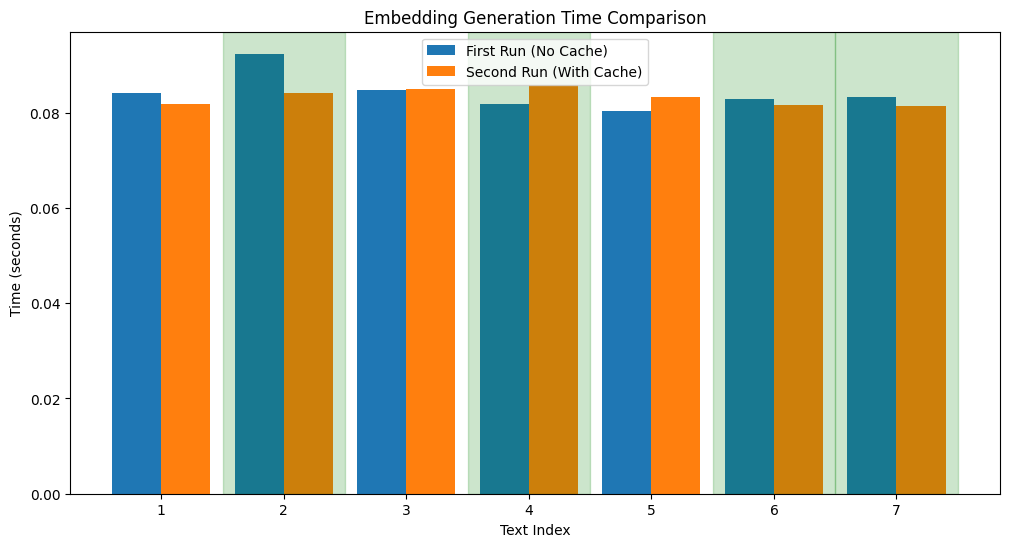


Comparison performance:
Total time first run: 0.5894 seconds
Total time second run: 0.5825 seconds
Time saved: 0.0069 seconds (1.17%)
Average time for repeated test texts - first run: 0.0830 seconds
Average time for repeated test texts - second run: 0.0828 seconds
Improvement for repeated test texts: 0.19%


In [9]:
### YOUR CODE HERE

# Configure the embedding model
YOUR_EMBED_MODEL_URL = "https://yij47k87rjciyxy7.us-east-1.aws.endpoints.huggingface.cloud"

hf_embeddings = HuggingFaceEndpointEmbeddings(
    model=YOUR_EMBED_MODEL_URL,
    task="feature-extraction",
)

# Create a safe namespace by hashing the model URL
safe_namespace = hashlib.md5(hf_embeddings.model.encode()).hexdigest()

# Set up the cache
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    hf_embeddings, store, namespace=safe_namespace
)

# Define test texts - some unique, some repeated
test_texts = [
    "This is a completely unique text about banking systems.",          #1
    "Another unique document about credit risk assessment.",            #2
    "This is a repeated text that will test our cache efficiency.",     #3
    "A fourth document about loan approval processes.",                 #4
    "This is a repeated text that will test our cache efficiency.",     #same as #3
    "This is a completely unique text about banking systems.",          #same as #1
    "A new unique document about fraud detection systems."
]

# Experiment function
def run_embedding_experiment(embedder, texts, experiment_name="Experiment"):
    print(f"Running {experiment_name}...")
    times = []
    
    # First run - should cache all texts
    print("First run - embedding all texts:")
    for i, text in enumerate(texts):
        start_time = time.time()
        embedding = embedder.embed_query(text)
        elapsed = time.time() - start_time
        times.append(elapsed)
        print(f"  Test text {i+1}: {elapsed:.4f} seconds")
    
    first_run_times = times.copy()

    # Reset the times array to store execution times of the new run
    times = []
    
    # Second run - should use cache for repeated texts
    print("\nSecond run - should use cache when possible:")
    for i, text in enumerate(texts):
        start_time = time.time()
        embedding = embedder.embed_query(text)
        elapsed = time.time() - start_time
        times.append(elapsed)
        print(f"  Test text {i+1}: {elapsed:.4f} seconds")
    
    second_run_times = times
    
    return first_run_times, second_run_times

# Run experiment with cache
first_run, second_run = run_embedding_experiment(cached_embedder, test_texts, "Cache-backed embeddings")

# Plot results
def plot_results(first_run, second_run, text_indices):
    plt.figure(figsize=(12, 6))
    
    # Bars for first run
    plt.bar(np.array(text_indices) - 0.2, first_run, width=0.4, label='First Run (No Cache)')
    
    # Bars for second run
    plt.bar(np.array(text_indices) + 0.2, second_run, width=0.4, label='Second Run (With Cache)')
    
    plt.xlabel('Text Index')
    plt.ylabel('Time (seconds)')
    plt.title('Embedding Generation Time Comparison')
    plt.legend()
    plt.xticks(text_indices)
    
    # Highlight repeated texts
    repeated_indices = [3, 5, 1, 6]  # Texts that are repeated (0-indexed)
    for idx in repeated_indices:
        plt.axvspan(idx + 0.5, idx + 1.5, alpha=0.2, color='green')
    
    plt.savefig('cache_experiment_results.png')
    plt.show()

# Plot the results
plot_results(first_run, second_run, range(1, len(test_texts) + 1))

# Calculate and print statistics
def print_stats(first_run, second_run):
    total_first = sum(first_run)
    total_second = sum(second_run)
    time_saved = total_first - total_second
    percent_saved = (time_saved / total_first) * 100
    
    # Find indices of repeated texts (0-indexed for the arrays)
    repeated_indices = [2, 4, 0, 5]  # Based on our test_texts definition
    
    # Calculate average time for repeated texts in both runs
    repeat_first_avg = sum([first_run[i] for i in repeated_indices]) / len(repeated_indices)
    repeat_second_avg = sum([second_run[i] for i in repeated_indices]) / len(repeated_indices)
    repeat_improvement = (repeat_first_avg - repeat_second_avg) / repeat_first_avg * 100
    
    print("\nComparison performance:")
    print(f"Total time first run: {total_first:.4f} seconds")
    print(f"Total time second run: {total_second:.4f} seconds")
    print(f"Time saved: {time_saved:.4f} seconds ({percent_saved:.2f}%)")
    print(f"Average time for repeated test texts - first run: {repeat_first_avg:.4f} seconds")
    print(f"Average time for repeated test texts - second run: {repeat_second_avg:.4f} seconds")
    print(f"Improvement for repeated test texts: {repeat_improvement:.2f}%")

print_stats(first_run, second_run)

# Clear the cache to compare with non-cached approach (optional)
# import shutil
# shutil.rmtree("./cache/")

### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [10]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [11]:
from langchain_core.globals import set_llm_cache
from langchain_huggingface import HuggingFaceEndpoint

YOUR_LLM_ENDPOINT_URL = "https://plqere42yvuvlaq7.us-east-1.aws.endpoints.huggingface.cloud"

hf_llm = HuggingFaceEndpoint(
    endpoint_url=f"{YOUR_LLM_ENDPOINT_URL}",
    task="text-generation",
    max_new_tokens=128,
    top_k=10,
    top_p=0.95,
    typical_p=0.95,
    temperature=0.01,
    repetition_penalty=1.03,
)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Setting up the cache can be done as follows:

In [12]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

<div style="background-color: #E6E6FA; padding: 10px; border-radius: 5px;">
<span style="color: black;">
<b> ANSWER:  </b> 

LLM Prompt Caching approach has a few limitations that are worth considering.  
1. <b> Consistency and Freshness Issues </b>: Cached responses can ne outdated when data or policies change.  

2. <b> Personalization Challenges </b>: Caching can help produce generic responses or solutions but difficult to provide personalized responses.  

3. <b> Storage and Management Overhead </b>: The application state doesn't persists between application restarts.  

4. <b> Security Considerations </b>: Cached responses might include data that shouldn't be reused such as across different users of a bank. Compliance concerns about storing customer interactions and customer profile can be a security risk.  

LLM Prompt Caching can be most useful to serve high-volume standardized requests or during peak times (when latency is critical), and for cost-sensitive operations.

LLM Prompt Caching would be of limited value for accessing time-sensitive market data, complex compliance situations, and use cases consuming dynamic content.

</span>
</div>

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Running experiment WITHOUT cache...
  Prompt 1: 0.0005 seconds
  Prompt 2: 0.0005 seconds
  Prompt 3: 0.0003 seconds
  Prompt 4: 0.0003 seconds
  Prompt 5: 0.0002 seconds
  Prompt 6: 0.0001 seconds
  Prompt 7: 0.0001 seconds

Running experiment WITH cache...
  Prompt 1: 7.6710 seconds
  Prompt 2: 7.8342 seconds
  Prompt 3: 0.0005 seconds
  Prompt 4: 7.8010 seconds
  Prompt 5: 0.0005 seconds
  Prompt 6: 7.7979 seconds
  Prompt 7: 0.0005 seconds


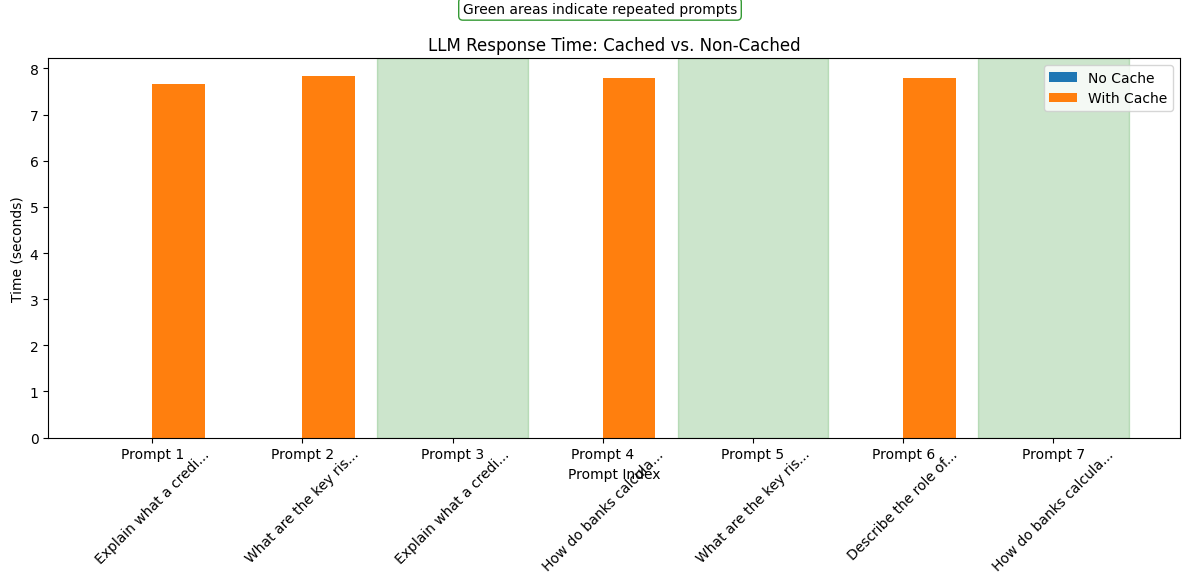


Performance Analysis:
Total time without cache: 0.0022 seconds
Total time with cache: 31.1056 seconds
Overall time saved: -31.1034 seconds (-1434383.09%)

Repeated Prompts Only:
Time without cache: 0.0007 seconds
Time with cache: 0.0014 seconds
Time saved on repeated prompts: -0.0007 seconds (-99.16%)

Average Response Times:
First-time requests: 0.0004 seconds
Repeated requests (no cache): 0.0002 seconds
Repeated requests (with cache): 0.0005 seconds
Cache speedup factor: 0.50x faster
-99.15569064505235


In [15]:
# Configure the LLM
YOUR_LLM_ENDPOINT_URL = "https://plqere42yvuvlaq7.us-east-1.aws.endpoints.huggingface.cloud"

def create_llm():
    return HuggingFaceEndpoint(
        endpoint_url=f"{YOUR_LLM_ENDPOINT_URL}",
        task="text-generation",
        max_new_tokens=128,
        top_k=10,
        top_p=0.95,
        typical_p=0.95,
        temperature=0.01,
        repetition_penalty=1.03,
    )

# Test prompts - mix of unique and repeated
test_prompts = [
    "Explain what a credit default swap is in simple terms.",
    "What are the key risk factors in retail banking?",
    "Explain what a credit default swap is in simple terms.",  # Repeated
    "How do banks calculate interest rates?",
    "What are the key risk factors in retail banking?",  # Repeated
    "Describe the role of a central bank in the economy.",
    "How do banks calculate interest rates?",  # Repeated
]

def run_llm_cache_experiment():
    """Run experiment comparing cached vs non-cached LLM calls"""
    
    # First test: No caching
    llm_no_cache = create_llm()
    
    print("Running experiment WITHOUT cache...")
    no_cache_times = []
    
    for i, prompt in enumerate(test_prompts):
        start_time = time.time()
        _ = llm_no_cache.invoke(prompt)
        elapsed = time.time() - start_time
        no_cache_times.append(elapsed)
        print(f"  Prompt {i+1}: {elapsed:.4f} seconds")
    
    # Second test: With caching
    set_llm_cache(InMemoryCache())
    llm_with_cache = create_llm()
    
    print("\nRunning experiment WITH cache...")
    with_cache_times = []
    
    for i, prompt in enumerate(test_prompts):
        start_time = time.time()
        _ = llm_with_cache.invoke(prompt)
        elapsed = time.time() - start_time
        with_cache_times.append(elapsed)
        print(f"  Prompt {i+1}: {elapsed:.4f} seconds")
    
    return no_cache_times, with_cache_times

# Visualize results
def plot_cache_comparison(no_cache_times, with_cache_times):
    indices = np.arange(len(test_prompts))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot bars
    no_cache_bars = ax.bar(indices - width/2, no_cache_times, width, label='No Cache')
    with_cache_bars = ax.bar(indices + width/2, with_cache_times, width, label='With Cache')
    
    # Add labels and title
    ax.set_xlabel('Prompt Index')
    ax.set_ylabel('Time (seconds)')
    ax.set_title('LLM Response Time: Cached vs. Non-Cached')
    ax.set_xticks(indices)
    ax.set_xticklabels([f"Prompt {i+1}" for i in indices])
    ax.legend()
    
    # Highlight repeated prompts
    repeat_indices = [2, 4, 6]  # 0-indexed positions of repeated prompts
    for idx in repeat_indices:
        plt.axvspan(idx-0.5, idx+0.5, alpha=0.2, color='green')
    
    # Add text annotations for prompt descriptions
    prompt_descriptions = [p[:20] + "..." for p in test_prompts]
    for i, desc in enumerate(prompt_descriptions):
        ax.annotate(desc, xy=(i, 0), xytext=(i, -0.2), 
                   ha='center', va='top', rotation=45)
    
    # Add note for repeated prompts
    ax.annotate('Green areas indicate repeated prompts', 
               xy=(0.5, 0.95), xycoords='figure fraction',
               ha='center', fontsize=10,
               bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('llm_cache_experiment_results.png')
    plt.show()

# Calculate and print statistics
def analyze_cache_performance(no_cache_times, with_cache_times):
    # Overall stats
    total_no_cache = sum(no_cache_times)
    total_with_cache = sum(with_cache_times)
    time_saved = total_no_cache - total_with_cache
    percent_saved = (time_saved / total_no_cache) * 100
    
    # Stats for repeated prompts only
    repeat_indices = [2, 4, 6]  # 0-indexed positions of repeated prompts
    
    repeat_no_cache = sum([no_cache_times[i] for i in repeat_indices])
    repeat_with_cache = sum([with_cache_times[i] for i in repeat_indices])
    repeat_time_saved = repeat_no_cache - repeat_with_cache
    repeat_percent_saved = (repeat_time_saved / repeat_no_cache) * 100
    
    # Print results
    print("\nPerformance Analysis:")
    print(f"Total time without cache: {total_no_cache:.4f} seconds")
    print(f"Total time with cache: {total_with_cache:.4f} seconds")
    print(f"Overall time saved: {time_saved:.4f} seconds ({percent_saved:.2f}%)")
    print("\nRepeated Prompts Only:")
    print(f"Time without cache: {repeat_no_cache:.4f} seconds")
    print(f"Time with cache: {repeat_with_cache:.4f} seconds")
    print(f"Time saved on repeated prompts: {repeat_time_saved:.4f} seconds ({repeat_percent_saved:.2f}%)")
    
    # Compare average response times
    avg_first_request = sum([no_cache_times[i] for i in range(len(no_cache_times)) if i not in repeat_indices]) / (len(no_cache_times) - len(repeat_indices))
    avg_repeat_no_cache = repeat_no_cache / len(repeat_indices)
    avg_repeat_with_cache = repeat_with_cache / len(repeat_indices)
    
    print("\nAverage Response Times:")
    print(f"First-time requests: {avg_first_request:.4f} seconds")
    print(f"Repeated requests (no cache): {avg_repeat_no_cache:.4f} seconds")
    print(f"Repeated requests (with cache): {avg_repeat_with_cache:.4f} seconds")
    print(f"Cache speedup factor: {avg_repeat_no_cache/avg_repeat_with_cache:.2f}x faster")
    
    return repeat_percent_saved

# Main experiment execution
def main():
    # Run the experiment
    no_cache_times, with_cache_times = run_llm_cache_experiment()
    
    # Plot the results
    plot_cache_comparison(no_cache_times, with_cache_times)
    
    # Analyze and get the savings percentage
    savings = analyze_cache_performance(no_cache_times, with_cache_times)
    print(savings)

# Execute the main function
if __name__ == "__main__":
    main()

## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [16]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | hf_llm
    )

Let's test it out!

In [17]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

"The document is a list of contributors to a project, with their names and possibly initials.\n\n1. The document is a list of contributors.\n2. The document is in PDF format.\n3. The document was created on January 23, 2025.\n4. The document has 22 pages.\n5. The document was produced by pdfTeX-1.40.26.\n6. The document was created using LaTeX with hyperref.\n7. The document's title is empty.\n8. The document's author is empty.\n9. The document's subject is empty.\n10. The document's keywords are empty.\n11. The"

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

In [18]:
# Verify LangSmith project is set up correctly
print(f"Current LangSmith project: {os.environ['LANGCHAIN_PROJECT']}")
print(f"Tracing enabled: {os.environ['LANGCHAIN_TRACING_V2']}")

# Import LangSmith client for trace retrieval
from langsmith import Client
client = Client()

Current LangSmith project: AIM Session 16 - 8fb65977
Tracing enabled: true


In [19]:
# Clear caches to start fresh if needed
import shutil
import os
import uuid
from datetime import datetime
shutil.rmtree("./cache/", ignore_errors=True)
from langchain_core.globals import set_llm_cache
set_llm_cache(None)  # Disable LLM cache

# Import LangSmith client
from langsmith import Client
client = Client()

# Generate unique run IDs for easy identification
no_cache_run_id = f"no_cache_{uuid.uuid4().hex[:8]}"
with_cache_run_id = f"with_cache_{uuid.uuid4().hex[:8]}"

# First run - no cache (with LangSmith tracing)
print("Running first query (no cache)...")
os.environ["LANGCHAIN_TRACING_RUN_ID"] = no_cache_run_id
os.environ["LANGCHAIN_TRACING_ENABLED"] = "true"
first_run_question = "What are the key innovations described in this paper?"
first_response = retrieval_augmented_qa_chain.invoke(
    {"question": first_run_question}
)
print(f"First run completed. Run ID: {no_cache_run_id}")

# Now run with cache populated
print("\nRunning second query (with cache)...")
os.environ["LANGCHAIN_TRACING_RUN_ID"] = with_cache_run_id
second_response = retrieval_augmented_qa_chain.invoke(
    {"question": first_run_question}  # Same question to leverage cache
)
print(f"Second run completed. Run ID: {with_cache_run_id}")

# Print LangSmith links for easy access
base_url = "https://smith.langchain.com/runs"
print(f"\nLangSmith links to view traces:")
print(f"No cache run: {base_url}/{no_cache_run_id}")
print(f"With cache run: {base_url}/{with_cache_run_id}")

Running first query (no cache)...
First run completed. Run ID: no_cache_f38b7e81

Running second query (with cache)...
Second run completed. Run ID: with_cache_f01b0171

LangSmith links to view traces:
No cache run: https://smith.langchain.com/runs/no_cache_f38b7e81
With cache run: https://smith.langchain.com/runs/with_cache_f01b0171


![Question](images/001.png)

![Question](images/002.png)

![Question 1](images/003.png)

![Question 1](images/004.png)

![Question](images/005.png)

![Question](images/006.png)

![Question](images/007.png)

![Question](images/008.png)

![Question](images/009.png)

![Question](images/010.png)

![Question](images/011.png)

![Question](images/012.png)